In [7]:
! pip install kaggle

In [8]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle competitions download dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 32.2MB/s]
 98% 531M/543M [00:02<00:00, 249MB/s]
100% 543M/543M [00:02<00:00, 241MB/s]
 97% 262M/271M [00:01<00:00, 256MB/s]
100% 271M/271M [00:01<00:00, 237MB/s]


In [12]:
! unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [13]:
! unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [14]:
!pip install tensorflow

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [17]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3

In [19]:
filenames = os.listdir('/content/train')

categories = []
for f_name in filenames:
  category = f_name.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

  
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [28]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})

In [29]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)

train_df =  train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [30]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [31]:
train_generator = train_datagen.flow_from_dataframe(train_df,"/content/train/",x_col='filename',y_col='category', target_size=Image_Size, class_mode='categorical', batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [33]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [43]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
1333/1333 [==============================] - 152s 114ms/step - loss: 0.5565 - accuracy: 0.7181 - val_loss: 0.6029 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 144s 108ms/step - loss: 0.5138 - accuracy: 0.7543 - val_loss: 0.4939 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 138s 104ms/step - loss: 0.4778 - accuracy: 0.7776 - val_loss: 0.5597 - val_accuracy: 0.7502 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 143s 108ms/step - loss: 0.4445 - accuracy: 0.7966 - val_loss: 0.3972 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 144s 108ms/step - loss: 0.4283 - accuracy: 0.8025 - val_loss: 0.3602 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 135s 101ms/step - loss: 0.4094 - accuracy: 0.8158 - val_loss: 0.4433 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 7/10
1333/1333 [============

In [44]:
model.save('model1_catsVsdogs_10epoch.h5')

In [45]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [50]:
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
test_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "/content/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [51]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [62]:
predict = predict[0:12500]

In [63]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

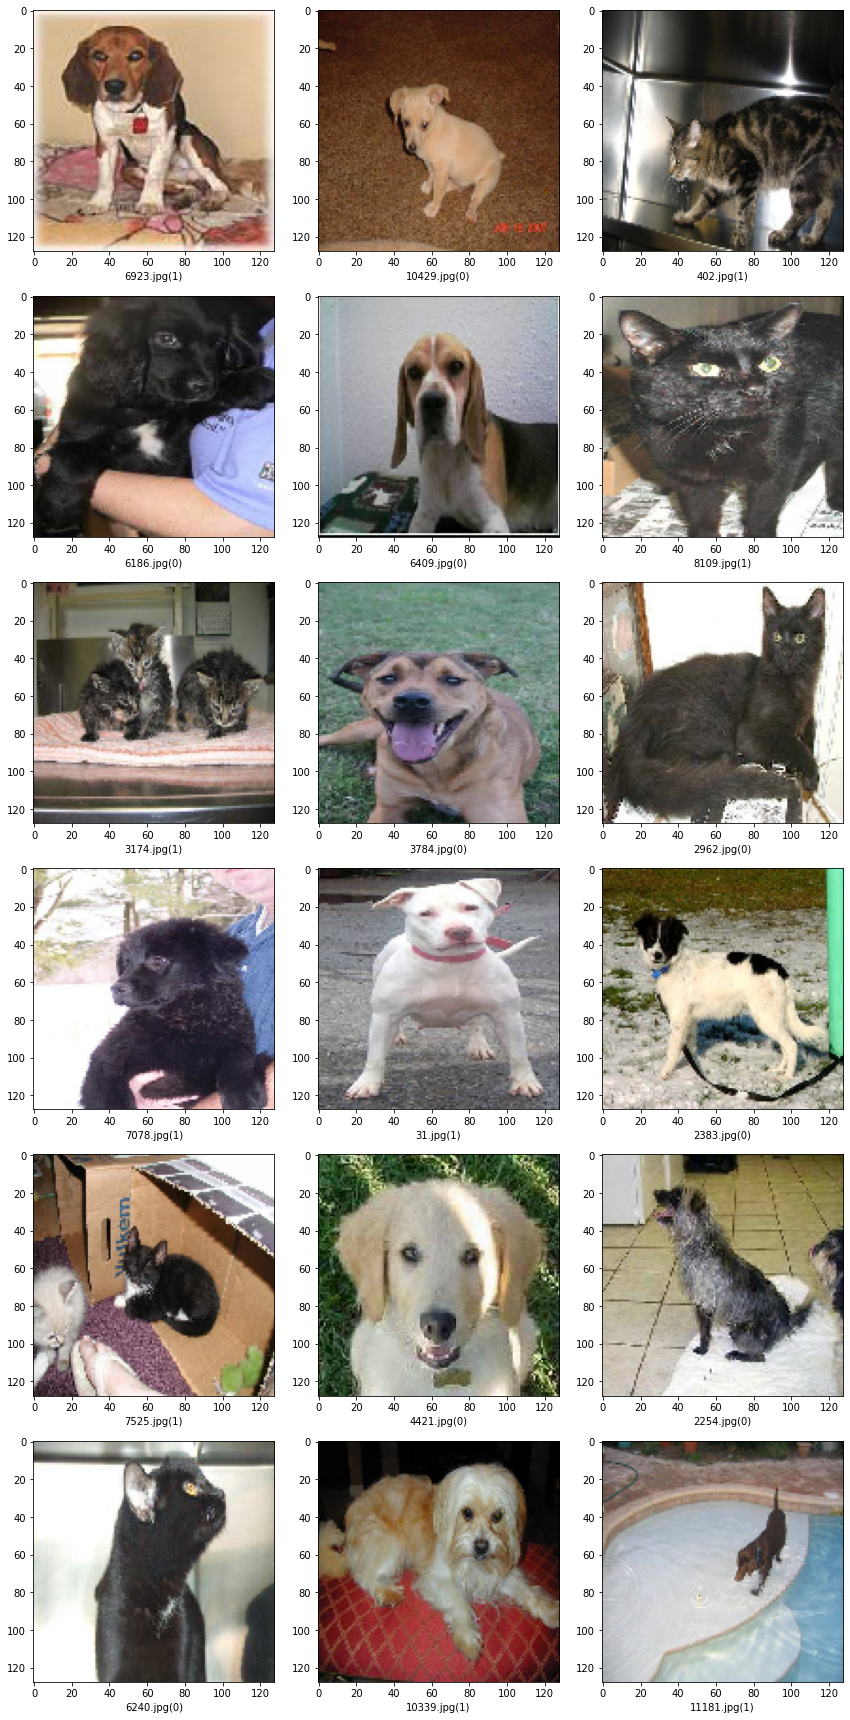

In [65]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [70]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("/content/Test Images/close-up-of-cat-wearing-sunglasses-while-sitting-royalty-free-image-1571755145.jpg")   #__image_path_TO_custom_image
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=np.argmax(model.predict([im])[0], axis=-1)
print(pred,results[pred])

0 cat


In [71]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("/content/Test Images/dog-4415649-18eab39206426b985f7a5f69e3146a2cd1a56c0d-s1100-c50.jpg")   #__image_path_TO_custom_image
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=np.argmax(model.predict([im])[0], axis=-1)
print(pred,results[pred])

1 dog


In [74]:
!sudo apt-get install python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-co

In [75]:
! cp model1_catsVsdogs_10epoch.h5 /content/GUI/

In [83]:
! cd /content/GUI

In [84]:
! python3 gui.py

/content
